# M-Test Notes

In [41]:
import time
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from csep.utils.plotting import plot_mfd
import csep
import csep.utils.stats as cstats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load Comcat catalog and UCERF3 forecasts

In [17]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter("magnitude > 3.95")
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 0.3399479389190674 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 3.9600000381469727 and Max Magnitude: 6.300000190734863



In [18]:
# UCERF3 stochastic event set
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

u3catalogs = []
for cat in csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs.append(cat.filter("magnitude > 3.95"))

## Towards an M-test

The M-test or Magnitude-test evaluates whether the magnitude-frequency distribution (MFD) of the observed catalog is different than the forecast. There exist several techniques to compare whether two samples originate from the same population distribution; such as, Kolmogorov-Smirnov, Kramer-von Mises, or Anderson-Darling for continuous distributions and exact Multinomial test or Chi-square for discrete distributions. The Kolmogorov-Smirnov test is the most straightforward to implement because the distribution of the test statistic has an analytical distribution function.

Two-sample non-parameteric tests for equality require computing empirical distribution functions from observed data sets. It's typical that magnitudes of earthquake forecasts and catalogs are discretized so that only certain observation are possible within a data set. The plots below show how the different discretizations effect the estimation of the KS statistics which is defined as $\sup{\lvert F(x)-G(x) \rvert}$, where $F(x)$ and $G(x)$ are empirical distribution functions.

It remains a question whether we can/should use the scipy implementation of the two-sample KS test.


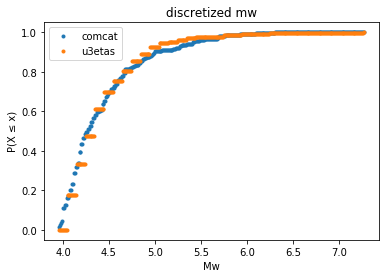

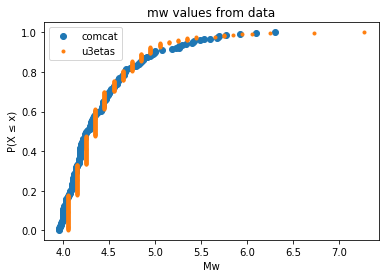

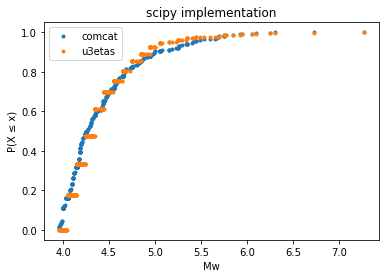

In [34]:
obs = comcat.get_magnitudes()
u3etas = u3catalogs[0].get_magnitudes()

# magnitude increment
dmw = 0.01
global_min = min([min(obs), min(u3etas)])
global_max = max([max(obs), max(u3etas)])

# magnitude bins
mws = arange(global_min, global_max+dmw, dmw)

# compute cdf function
# this computes ecdf everytime, can compute once and store. use different function
cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw), mws))
cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw), mws))

figure()
title("discretized mw")
plot(mws, cdf1, '.', label='comcat')
plot(mws, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

figure()
title("mw values from data")
plot(*cstats.ecdf(obs), 'o', label='comcat')
plot(*cstats.ecdf(u3etas), '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

# plotting ecdf from scipy implementation
d1 = sort(obs)
d2 = sort(u3etas)
n1 = d1.shape[0]
n2 = d2.shape[0]
d_all = concatenate([d1, d2])
cdf1 = searchsorted(d1, d_all, side='right') / n1
cdf2 = searchsorted(d2, d_all, side='right') / n2

figure()
title("scipy implementation")
plot(d_all, cdf1, '.', label='comcat')
plot(d_all, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
h = legend()

The top figure defines an arbitrary set of $M_w$ values to compute the ECDF so that the KS statistics is computed at consistent frequencies between the simulation and the data.

The middle figure defines cumulative frequencies at only points defined by the data. This operation produces an ambiguous KS statistic because there are multiple cumulative frequencies for each catalog value. We can discard this approach.

The bottom figure shows the scipy implementation which pools the data under the null-hypothesis and computes cumulative frequencies for each value in the pooled data. This approach does not suffer the same issue as seen in the middle figure. However, by defining cumulative frequncies at values not observed in the catalog, the resulting KS statistics are potentially larger than they would be in the top case.

### Implementation of KS test using Discretized $M_w$ approach

To compare against the scipy implementation, we use the following implementation for the two-sample KS test based on computing the emprical distribution function at discretized values.

In [42]:
import scipy

def my_ks_2samp(data1, data2, dmw=0.01):
    # real version should force to be numpy arrays, etc.
    
    global_min = min([min(data1), min(data2)])
    global_max = max([max(data1), max(data2)])
    
    mws = arange(global_min, global_max+dmw, dmw)
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(d1, mw), mws))
    cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(d2, mw), mws))
        
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    cdf1 = np.array(cdf1)
    cdf2 = np.array(cdf2)
    
    d = np.max(np.absolute(cdf1-cdf2))
    en = np.sqrt(n1 * n2 / (n1 + n2))
    
    # the constants are from stephens, 1974. seem to be simplification for computing sqrt(n). is this needed today?
    prob = scipy.stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
    
    return(d, prob)

## Testing the M-test

1. Generate collection of RVs from known distribution, called $M_0$.
2. Generate $N$ collections of RVs from same distribution in 1, called $M_i$.
3. For all $M_i$, perform KS test and aggreate p-values using methods above.

Since we are comparing two collections of RVs sampled from the same distribution we expect that the individual and aggregate statistics from the KS test reflect this.

### For Scipy Implementation

rejected 60 out of 10000 simluations.
7871.731537160848 1.0


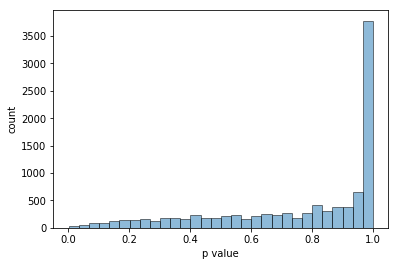

In [52]:
from scipy.stats import poisson, ks_2samp
from scipy.stats.distributions import chi2

mu = 1.0
N = 10000
m0 = poisson.rvs(mu, size=10000)
mi = [poisson.rvs(mu, size=10000) for _ in range(N)]
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = ks_2samp(m0, mi[idx])
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf()
p_values[p_values >= 1.0] = 1.0

print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

rejected 10000 out of 10000 simluations.
5359937.154507008 0.0


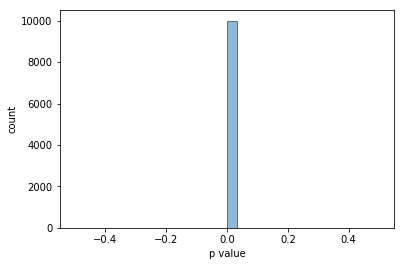

In [36]:
from scipy.stats import poisson
from scipy.stats.distributions import chi2

mu = 1.0
N = 10000
m0 = poisson.rvs(mu, size=10000)
mi = [poisson.rvs(mu, size=10000) for _ in range(N)]
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = my_ks_2samp(m0, mi[idx])
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf()
p_values[p_values >= 1.0] = 1.0

print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

The scipy implementation handles this test case appropriately. However, the implementation where the ECDF is computed at discrete points fails if the discretization effectively downsamples one of the two data sets. I conclude that it's reasonable to use the Scipy implementation of the two-sample Kolmogorov-Smirnov test.

## Testing the M-test using UCERF3

### For Scipy Implementation 

rejected 134 out of 9999 simluations.
11368.977749600002 1.0


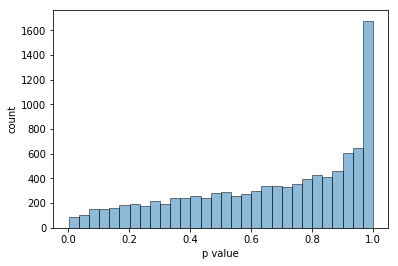

In [37]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = ks_2samp(m0_mws, mi_mws)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

rejected 9999 out of 9999 simluations.
157900.99526728518 0.0


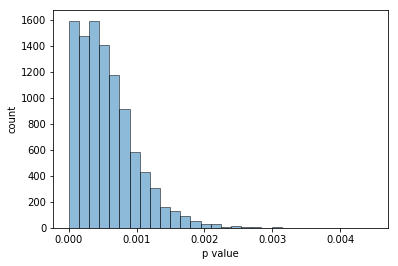

In [39]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = my_ks_2samp(m0_mws, mi_mws, dmw=0.01)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

These tests show that the implementation from scipy provides test results consistent with our observations, and can be used to implement the M-test. The approach for estimating probabilities at given values does not produce consistent results. Possible alternative solution could be Turnbull [1976]. Will revisit this once a reasonable M-test implementation can be shared.

## M-test of UCERF3-ETAS against observed data

rejected 10000 out of 10000 simluations.
128447.37542962175 0.0


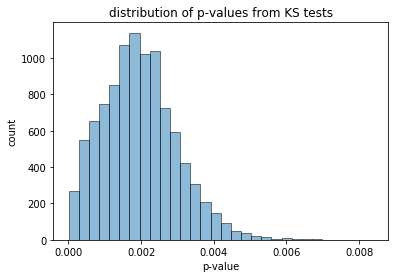

In [48]:
obs = comcat.get_magnitudes()
alpha = 0.05

rejections = 0
p_values = []

for u3cat in u3catalogs:
    mws = u3cat.get_magnitudes()
    d, p_val = ks_2samp(obs, mws)
    p_values.append(p_val)
    if p_value < alpha:
        rejections = rejections + 1
        
p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('p-value')
h = ylabel('count')
h = title('distribution of p-values from KS tests')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# display rejection
print('rejected {} out of {} simluations.'.format(rejections, len(u3catalogs)))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

## Conclusions

These notes show a possible implementation of the M-test based on Kolmogorov-Smirnov statistics. KS statistics are based on estimating ECDFs and are very strict for large numbers of observations. This means that small deviations between the two result in rejecting the null-hypothesis.

When I apply this test assuming that both observations and data come from a known distribution (a Poisson distribution and UCERF3-ETAS, repsectively), I find that the M-test does not incorrectly reject the correct null-hypothesis. When the M-test is applied to an observed catalog the M-test rejects each simulation and the stochastic event set as a whole.

It seems that this implementation might be too strict, for the overall purposes of the M-test.

## Discussion

Our test implementation using the scipy implementation produces constisent results for both Poisson and UCERF-ETAS tests. However, on first glace, the test appears to be overly strict for the purposes of CSEP. The current M-test implementation asks "Does the forecast and the observation originate from the same distribution function?", but we are actually asking if the simulated and observed magnitude-frequency distributions are consistent with one another.

We reject the null-hypothesis for all simulations in the stochastic event set. Using Fisher's combined test we reject the collection of tests as a whole. This poses some questions in regards to this implementation of the M-test using the scipy implementation of KS statistics. 

The KS statistic is based on the the maximum absolute distance between the observed and cumulative distribution functions. It seems that we are biasing the estimation of this parameter by treating the censored data points. This was meant to be solved by computing the empirical distribution functions at evenly discretized points.

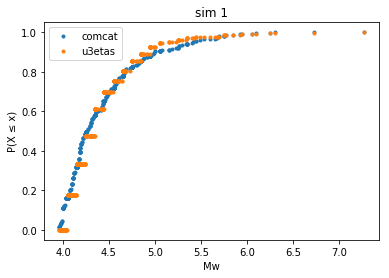

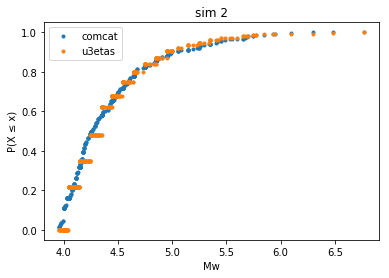

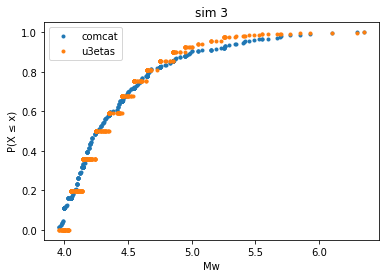

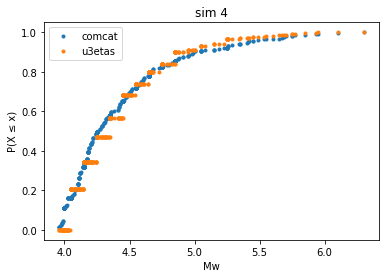

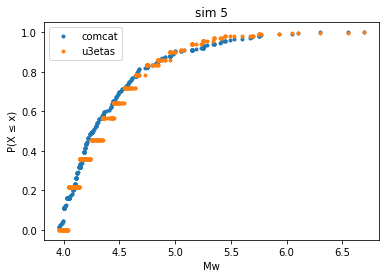

In [53]:
# plotting ecdf from scipy implementation
n_plots = 5
for idx in range(n_plots):
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    d1 = sort(obs)
    d2 = sort(u3etas)
    n1 = d1.shape[0]
    n2 = d2.shape[0]
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2

    figure()
    title("sim {}".format(idx+1))
    plot(d_all, cdf1, '.', label='comcat')
    plot(d_all, cdf2, '.', label='u3etas')
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

These figures show the empirical distribution functions used to compute the KS statistics used in the M-test. Visually, these plots indicate that the forecast ECDFs are seemingly consistent with the observed values.

Another way of implementing this test would be to discretize the magnitude bins and compute empirical distributions for the counts of the magnitudes in each bin. It seems that the forecast does not actually sample from the same distribution as the process generating seismicity, so this test will likely fail. Therefore, it seems more useful to devise a test that answers whether the forecast is consistent with the data.

## References

Turnbull, B. W. (1976). The empirical distribution function with arbitrarily grouped, censored and truncated data. *Journal of the Royal Statistical Society. Series B (Methodological)*, 290-295.